In [1]:
import pandas as pd

df = pd.read_csv("G:/My Drive/Data-Centric Solutions/07. Blog Posts/kedro/data/creditcard.csv")

In [2]:
df['transaction_id'] = df.index

In [14]:
import glob
import os
def delete_file():
    # Get a list of all HDF5 files in the current directory
    hdf5_files = glob.glob('*.hdf5')

    # Print each HDF5 file name
    for file in hdf5_files:
        os.remove(file)

    # Get a list of all JSON files in the current directory
    json_files = glob.glob('*.json')

    # Print each JSON file name
    for file in json_files:
        os.remove(file)

In [3]:
# # split data
# from sklearn.model_selection import train_test_split

# seed = 42
# train_df, holdout_df = train_test_split(df, test_size=0.2, random_state=seed)

In [4]:
from sdv.metadata import SingleTableMetadata
def create_metadata(df):
    df_fraud = df.loc[df["Class"] == 1]
    df_fraud.head(5)
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df_fraud)

    metadata.update_column(
        column_name='transaction_id',
        sdtype='id')

    # set primary key 
    metadata.set_primary_key(column_name='transaction_id')
    metadata.validate()
    return metadata, df_fraud

In [5]:
import warnings
from sdv.single_table import TVAESynthesizer

def create_synthetic_data(metadata, df_fraud):
    warnings.filterwarnings('ignore', category=FutureWarning)

    synthesizer = TVAESynthesizer(
        metadata, # required
        enforce_min_max_values=True,
        enforce_rounding=False,
        epochs=1000
    )
    synthesizer.fit(df_fraud)

    synthetic_data = synthesizer.sample(num_rows=10000)
    return synthetic_data

In [6]:
from sklearn.model_selection import train_test_split

def split_data(df, synthetic_data, synth):

    train, holdout_df = train_test_split(df, test_size=0.2, random_state=42)
    
    if synth is True:
        train_df = pd.concat([train, synthetic_data], ignore_index=True)
    else:
        train_df = train
        
    
    return train_df, holdout_df


In [7]:
from ludwig.api import LudwigModel
import requests
import yaml


# URL of the raw YAML file in the GitHub repository
def run_experiment(url):
    url = url

    # Send a GET request to the URL
    response = requests.get(url)

    # Raise an exception if the request was unsuccessful
    response.raise_for_status()

    # Load the YAML data from the response text
    config = yaml.safe_load(response.text)

    # Set your output directory path
    output_dir = r"C:\Users\johna\anaconda3\envs\synth-env\synthetic_data_credit_cards\modelruns"

    # Set up your experiment
    model = LudwigModel(config=config)
    experiment_results = model.experiment(
      dataset=train_df,
      output_directory=output_dir
    )
    return model

C:\Users\johna\anaconda3\envs\synth-env\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
C:\Users\johna\anaconda3\envs\synth-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def analysis(model, holdout_df):
    holdout_df = holdout_df.reset_index(drop=True)
    predictions, _ = model.predict(dataset=holdout_df)

    model_analysis_df = predictions.merge(right=holdout_df, left_index=True, right_index=True)
    model_analysis_df['Class_predictions'] = model_analysis_df['Class_predictions'].map({True: 1, False: 0})
    return model_analysis_df

In [9]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score, f1_score, auc
import matplotlib.pyplot as plt

def model_diagnostics(model_analysis_df):
# Calculate confusion matrix
    cm = confusion_matrix(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
    print('Confusion Matrix:')
    print(cm)

    # Calculate precision, recall and F1 score
    precision = precision_score(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
    recall = recall_score(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
    f1 = f1_score(model_analysis_df['Class'], model_analysis_df['Class_predictions'])

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(model_analysis_df['Class'], model_analysis_df['Class_predictions'])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


Detected metadata:
{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "Time": {
            "sdtype": "numerical"
        },
        "V1": {
            "sdtype": "numerical"
        },
        "V2": {
            "sdtype": "numerical"
        },
        "V3": {
            "sdtype": "numerical"
        },
        "V4": {
            "sdtype": "numerical"
        },
        "V5": {
            "sdtype": "numerical"
        },
        "V6": {
            "sdtype": "numerical"
        },
        "V7": {
            "sdtype": "numerical"
        },
        "V8": {
            "sdtype": "numerical"
        },
        "V9": {
            "sdtype": "numerical"
        },
        "V10": {
            "sdtype": "numerical"
        },
        "V11": {
            "sdtype": "numerical"
        },
        "V12": {
            "sdtype": "numerical"
        },
        "V13": {
            "sdtype": "numerical"
        },
        "V14": {
            "sdtype": "numerical"
   

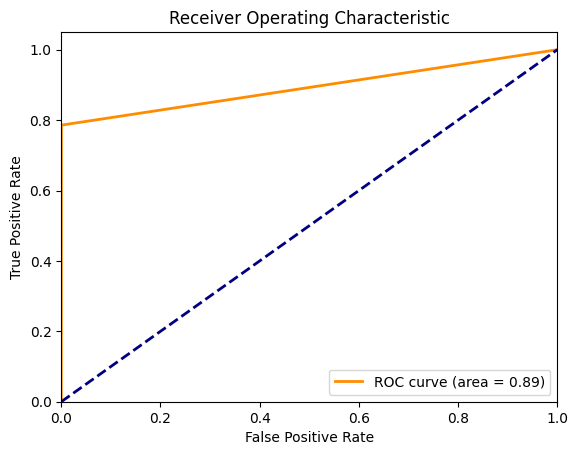

In [10]:
metadata, df_fraud = create_metadata(df)
synthetic_data = create_synthetic_data(metadata, df_fraud)
synth = False
train_df, holdout_df = split_data(df, synthetic_data, synth)
model = run_experiment(url='https://raw.githubusercontent.com/john-adeojo/Credit-Card-Fraud-Model-Registry/main/model%20yaml%20files/model_1a.yaml')
model_analysis_df = analysis(model, holdout_df)
model_diagnostics(model_analysis_df)
delete_file()

Confusion Matrix:
[[56844    20]
 [   23    75]]
Precision: 0.7894736842105263
Recall: 0.7653061224489796
F1 Score: 0.7772020725388602


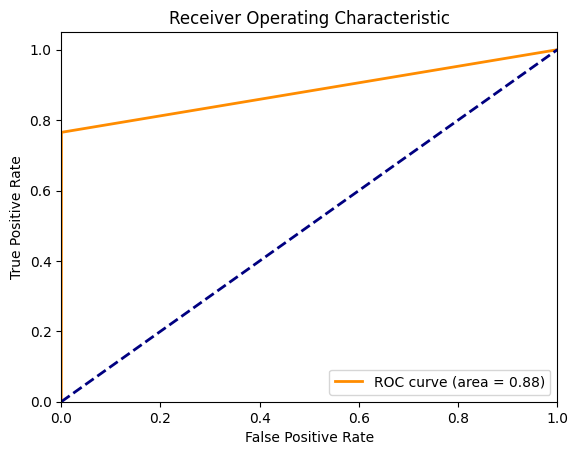

In [11]:
synth = True
train_df, holdout_df = split_data(df, synthetic_data, synth)
model = run_experiment(url='https://raw.githubusercontent.com/john-adeojo/Credit-Card-Fraud-Model-Registry/main/model%20yaml%20files/synthetic_data/model_sythnthetic_data.yaml')
model_analysis_df = analysis(model, holdout_df)
model_diagnostics(model_analysis_df)
delete_file()